# Use Snowpark_OpenAI Notebook template

In [1]:
!!pip install "snowflake-connector-python[pandas]"

['Collecting snowflake-connector-python[pandas]',
 '  Using cached https://files.pythonhosted.org/packages/f8/c7/03d2ca5e460acb3a31d70ee17584fbc6fe828a52c9f83bbb20a392b8988b/snowflake_connector_python-3.7.1-cp39-cp39-manylinux_2_17_x86_64.manylinux2014_x86_64.whl',
 'Collecting requests<3.0.0',
 '  Using cached https://files.pythonhosted.org/packages/70/8e/0e2d847013cb52cd35b38c009bb167a1a26b2ce6cd6965bf26b47bc0bf44/requests-2.31.0-py3-none-any.whl',
 'Collecting tomlkit',
 '  Using cached https://files.pythonhosted.org/packages/07/fa/c96545d741f2fd47f565e4e06bfef0962add790cb9c2289d900102b55eca/tomlkit-0.12.4-py3-none-any.whl',
 'Collecting cryptography<43.0.0,>=3.1.0',
 '  Using cached https://files.pythonhosted.org/packages/d4/fa/057f9d7a5364c86ccb6a4bd4e5c58920dcb66532be0cc21da3f9c7617ec3/cryptography-42.0.5-cp39-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl',
 'Collecting urllib3<2.0.0,>=1.21.1; python_version < "3.10"',
 '  Using cached https://files.pythonhosted.org/package

In [2]:
!pip install -q matplotlib seaborn xgboost

ERROR: snowflake-ml-python 1.0.10 has requirement packaging<24,>=20.9, but you'll have packaging 24.0 which is incompatible.
ERROR: snowflake-ml-python 1.0.10 has requirement pandas<2,>=1.0.0, but you'll have pandas 2.2.1 which is incompatible.
ERROR: snowflake-ml-python 1.0.10 has requirement xgboost<2,>=1.7.3, but you'll have xgboost 2.0.3 which is incompatible.
ERROR: jupyterlab 3.2.4 has requirement jupyter-server~=1.4, but you'll have jupyter-server 2.0.0a1 which is incompatible.
ERROR: jupyterlab-server 2.25.3 has requirement jsonschema>=4.18.0, but you'll have jsonschema 3.2.0 which is incompatible.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [37]:
import pandas as pd # package for high-performance, easy-to-use data structures and data analysis
import numpy as np # fundamental package for scientific computing with Python
import matplotlib
import matplotlib.pyplot as plt # for plotting

import seaborn as sns # for making plots with seaborn
color = sns.color_palette()

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

import datetime

# Preprocessing, modelling and evaluating
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_auc_score, classification_report, accuracy_score,precision_score,recall_score,f1_score,matthews_corrcoef
from sklearn.model_selection import StratifiedKFold, cross_val_score, KFold
from xgboost import XGBClassifier
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

# Read Customer and Payment data from Snowflake respective tables

In [2]:
#Import all snowflake connection details from template variables.

db_user = os.getenv('sf_user')
db_password =  'Password@2023' #os.getenv('sf_password')
db_account = os.getenv('sf_account')
db_database =  os.getenv('sf_db')
db_role = os.getenv('sf_role')
db_warehouse = 'FOSFOR_FDC'
db_schema = 'PUBLIC'

In [3]:
from snowflake.snowpark.session import Session
connection_params = {
    'user': db_user,
    'password': db_password,
    'account': db_account,
    'warehouse': db_warehouse,
    'database': db_database,
    'schema': db_schema,
    'role': db_role
}
session = Session.builder.configs(connection_params).create()

In [4]:
session.sql('use warehouse FOSFOR_FDC;').collect()
session.sql('use database FDC_DATA_MANISH;').collect()
session.sql('use schema FDC_DATA_MANISH.PUBLIC;').collect()

cc_customer = session.table('FDC_DATA_MANISH.PUBLIC.CC_CUSTOMER_DATA').to_pandas()
cc_payment = session.table('FDC_DATA_MANISH.PUBLIC.CC_PAYMENT_DATA').to_pandas()

# Reverse Data Engineering to get Raw data

In [5]:
cc_customer['FEA_2'] = cc_customer['FEA_2'].replace([0],np.nan)

In [6]:
cc_payment['PROD_LIMIT'] = cc_payment['PROD_LIMIT'].replace([0],np.nan)
cc_payment['HIGHEST_BALANCE'] = cc_payment['HIGHEST_BALANCE'].replace([0],np.nan)

cc_payment['UPDATE_DATE'] = cc_payment['UPDATE_DATE'].replace(['31/12/9999'],np.nan)
cc_payment['REPORT_DATE'] = cc_payment['REPORT_DATE'].replace(['31/12/9999'],np.nan)

# Check Missing Value/data

In [7]:
# checking missing data
def get_missing_data(df):
    total = df.isnull().sum().sort_values(ascending = False)
    percent = (df.isnull().sum()/df.isnull().count()*100).sort_values(ascending = False)
    percent = round(percent,2)
    missing_df  = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
    print( missing_df.head(20))
    return None

In [8]:
get_missing_data(cc_customer)

        Total  Percent
FEA_2     149    13.24
LABEL       0     0.00
ID          0     0.00
FEA_1       0     0.00
FEA_3       0     0.00
FEA_4       0     0.00
FEA_5       0     0.00
FEA_6       0     0.00
FEA_7       0     0.00
FEA_8       0     0.00
FEA_9       0     0.00
FEA_10      0     0.00
FEA_11      0     0.00


In [9]:
get_missing_data(cc_payment)

                 Total  Percent
PROD_LIMIT        6118    74.16
REPORT_DATE       1114    13.50
HIGHEST_BALANCE    409     4.96
UPDATE_DATE         26     0.32
OVD_T3               0     0.00
OVD_T2               0     0.00
OVD_T1               0     0.00
ID                   0     0.00
PROD_CODE            0     0.00
PAY_NORMAL           0     0.00
OVD_SUM              0     0.00
NEW_BALANCE          0     0.00


In [10]:
def data_profile(df):
    stats = []
    for col in df.columns:
        stats.append((col, df[col].nunique(), df[col].isnull().sum() * 100 / df.shape[0], df[col].value_counts(normalize=True, dropna=False).values[0] * 100, df[col].dtype))

    stats_df = pd.DataFrame(stats, columns=['Feature', 'Unique_values', 'Percentage of missing values', 'Percentage of values in the biggest category', 'type'])
    stats_df.sort_values('Percentage of missing values', ascending=True)
    return stats_df

In [11]:
data_profile(cc_customer)

,Feature,Unique_values,Percentage of missing values,Percentage of values in the biggest category,type
0,LABEL,2,0.000000,80.000000,float64
1,ID,1125,0.000000,0.088889,float64
2,FEA_1,6,0.000000,42.311111,float64
3,FEA_2,158,13.244444,13.244444,float64
4,FEA_3,3,0.000000,60.800000,float64
5,FEA_4,229,0.000000,3.022222,float64
6,FEA_5,2,0.000000,92.888889,float64
7,FEA_6,10,0.000000,41.333333,float64
8,FEA_7,10,0.000000,61.244444,float64
9,FEA_8,52,0.000000,8.711111,float64


In [12]:
data_profile(cc_payment)

,Feature,Unique_values,Percentage of missing values,Percentage of values in the biggest category,type
0,ID,1125,0.000000,0.666667,int32
1,OVD_T1,21,0.000000,90.606061,int8
2,OVD_T2,16,0.000000,95.587879,int8
3,OVD_T3,33,0.000000,96.763636,int8
4,OVD_SUM,393,0.000000,88.848485,int16
5,PAY_NORMAL,37,0.000000,11.030303,int8
6,PROD_CODE,21,0.000000,54.824242,int8
7,PROD_LIMIT,321,74.157576,74.157576,float64
8,UPDATE_DATE,3041,0.315152,0.315152,object
9,NEW_BALANCE,3939,0.000000,46.836364,float64


In [13]:
cc_customer['FEA_2'] = cc_customer['FEA_2'].replace([np.nan],cc_customer['FEA_2'].mean())

In [14]:
cc_payment['HIGHEST_BALANCE'] = cc_payment['HIGHEST_BALANCE'].replace([np.nan],0)

In [15]:
cc_customer.columns

Index(['LABEL', 'ID', 'FEA_1', 'FEA_2', 'FEA_3', 'FEA_4', 'FEA_5', 'FEA_6',
       'FEA_7', 'FEA_8', 'FEA_9', 'FEA_10', 'FEA_11'],
      dtype='object')

In [16]:
Total_features=['FEA_1', 'FEA_2', 'FEA_3', 'FEA_4', 'FEA_5', 'FEA_6',
       'FEA_7', 'FEA_8', 'FEA_9', 'FEA_10', 'FEA_11']

In [17]:
cat_features = ['FEA_3','FEA_5','FEA_6','FEA_9']
num_features = ['FEA_1','FEA_2','FEA_4','FEA_7','FEA_8','FEA_10','FEA_11']

In [18]:
def standerdisation(df,num_cols):
# copy of datasets
    df_stand = df.copy()

    # apply standardization on numerical features
    for i in num_cols:

        # fit on training data column
        scale = StandardScaler().fit(df_stand[[i]])

        # transform the training data column
        df_stand[i] = scale.transform(df_stand[[i]])
        
    return df_stand

In [19]:
cc_customer_std =  standerdisation(cc_customer,num_features)

In [20]:
feat_cols=[cols for cols  in cc_customer_std.columns if cols not in ['LABEL','ID']]

# Preparing data for model

In [21]:
X_train, X_test, y_train, y_test=train_test_split(cc_customer_std[feat_cols],cc_customer_std[['LABEL']],test_size=0.15)

In [24]:
X_train.head()

,index,FEA_1,FEA_2,FEA_3,FEA_4,FEA_5,FEA_6,FEA_7,FEA_8,FEA_9,FEA_10,FEA_11
0,0,1.097352,0.416866,3.0,0.091809,2.0,11.0,0.056269,0.183361,3.0,-0.087361,0.233161
1,1,1.097352,0.510247,3.0,4.288361,2.0,11.0,1.403133,-1.318688,5.0,-0.686229,2.241331
2,2,-0.349070,-0.143420,1.0,0.238858,2.0,15.0,-1.964028,0.850939,4.0,1.871948,0.555094
3,3,1.097352,-0.765960,3.0,-0.564256,1.0,11.0,1.403133,-0.484216,4.0,-0.686065,0.584161
4,4,1.097352,-0.890468,3.0,-0.654748,2.0,11.0,0.056269,0.934386,4.0,-0.685862,-1.190396


In [25]:
y_train.head()

,index,LABEL
0,0,0.0
1,1,1.0
2,2,0.0
3,3,0.0
4,4,0.0


In [26]:
X_train.reset_index(inplace=True)
X_test.reset_index(inplace=True)
y_train.reset_index(inplace=True)
y_test.reset_index(inplace=True)

X_train.drop(columns=['index'],axis=1,inplace=True)
X_test.drop(columns=['index'],axis=1,inplace=True)
y_train.drop(columns=['index'],axis=1,inplace=True)
y_test.drop(columns=['index'],axis=1,inplace=True)

print('Shape of Train features :-',X_train.shape)
print('Shape of Test features  :-',X_test.shape)

print('Shape of Train Target   :-',y_train.shape)
print('Shape of Test Target    :-',y_test.shape)
y_train = y_train['LABEL'].copy()
y_test = y_test['LABEL'].copy()

Shape of Train features :- (956, 12)
Shape of Test features  :- (169, 12)
Shape of Train Target   :- (956, 2)
Shape of Test Target    :- (169, 2)


# Random Forest Classifier

In [38]:
forest_model = RandomForestClassifier(random_state=1)
forest_model.fit(X_train, y_train)
y_pred =forest_model.predict(X_test)

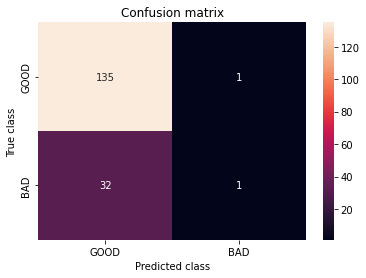

In [39]:
n_errors = (y_pred != y_test).sum()
LABELS = ['GOOD', 'BAD']
conf_matrix = confusion_matrix(y_test, y_pred.round())
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

# XGBoost

In [40]:
xgb_model = XGBClassifier(random_state=1)
xgb_model.fit(X_train, y_train)
y_pred =xgb_model.predict(X_test)

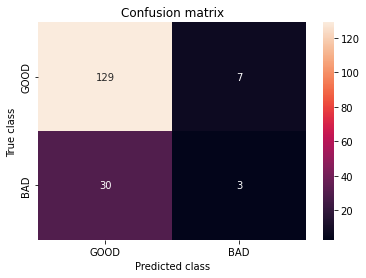

In [41]:
n_errors = (y_pred != y_test).sum()
LABELS = ['GOOD', 'BAD']
conf_matrix = confusion_matrix(y_test, y_pred.round())
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

# Defining Hyperparameters for Model

In [68]:
n_estimators = [5,20,50,100,200] # number of trees in the random forest
max_depth = [int(x) for x in np.linspace(5, 20, num = 5)] # maximum number of levels allowed in each decision tree
min_samples_split = [2, 6, 10, 50, 100] # minimum sample number to split a node
min_samples_leaf = [1, 3, 4,5,10] # minimum sample number that can be stored in a leaf node
bootstrap = [True, False] # method used to sample data points

random_grid = {'n_estimators': n_estimators,
'max_depth': max_depth,
'min_samples_split': min_samples_split,
'min_samples_leaf': min_samples_leaf,
'bootstrap': bootstrap}

In [69]:
rf = RandomForestClassifier()

In [66]:
from sklearn.model_selection import RandomizedSearchCV
rf_random = RandomizedSearchCV(estimator = rf,param_distributions = random_grid,
               n_iter = 100, cv = 5, verbose=2, random_state=35, n_jobs = -1)

In [67]:
rf_random.fit(X_train, y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
235 fits failed out of a total of 500.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
95 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/conda/lib/python3.9/site-packages/sklearn/base.py", line 1145, in wrapper
    estimator._validate_params()
  File "/opt/conda/lib/python3.9/site-packages/sklearn/base.py", line 638, in _validate_params
    validate_parameter_constraints(
  File "/opt/conda/lib/python3.9/site-packages/sklearn/utils/_par

RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [5, 8, 12, 16, 20],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 3, 4, 5, 10],
                                        'min_samples_split': [2, 6, 10, 50,
                                                              100],
                                        'n_estimators': [5, 20, 50, 100, 200]},
                   random_state=35, verbose=2)

In [60]:
print ('Random grid: ', random_grid, '\n')
# print the best parameters
print ('Best Parameters: ', rf_random.best_params_, ' \n')

Random grid:  {'n_estimators': [5, 20, 50, 100, 200], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 14, 19, 24, 28, 33, 38, 43, 47, 52, 57, 62, 66, 71, 76, 81, 85, 90, 95, 100], 'min_samples_split': [2, 6, 10, 50, 100], 'min_samples_leaf': [1, 3, 4, 5, 10], 'bootstrap': [True, False]} 

Best Parameters:  {'n_estimators': 5, 'min_samples_split': 50, 'min_samples_leaf': 10, 'max_features': 'sqrt', 'max_depth': 66, 'bootstrap': False}  



In [62]:
#Use the best parameter
randmf = RandomForestClassifier(n_estimators = 5, min_samples_split = 50, min_samples_leaf= 10, max_features = 'sqrt', max_depth= 66, bootstrap=False) 
randmf.fit( X_train, y_train) 

RandomForestClassifier(bootstrap=False, max_depth=66, min_samples_leaf=10,
                       min_samples_split=50, n_estimators=5)

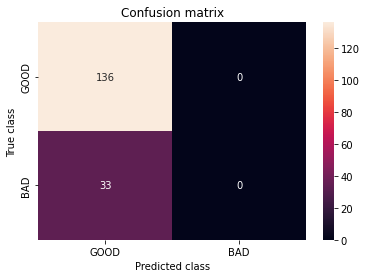

In [63]:
y_pred =randmf.predict(X_test)
n_errors = (y_pred != y_test).sum()
LABELS = ['GOOD', 'BAD']
conf_matrix = confusion_matrix(y_test, y_pred.round())
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()